In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/jigsaw-multilingual-toxic-comment-classification/validation-processed-seqlen128.csv
/kaggle/input/jigsaw-multilingual-toxic-comment-classification/jigsaw-toxic-comment-train-processed-seqlen128.csv
/kaggle/input/jigsaw-multilingual-toxic-comment-classification/jigsaw-unintended-bias-train.csv
/kaggle/input/jigsaw-multilingual-toxic-comment-classification/validation.csv
/kaggle/input/jigsaw-multilingual-toxic-comment-classification/test-processed-seqlen128.csv
/kaggle/input/jigsaw-multilingual-toxic-comment-classification/jigsaw-toxic-comment-train.csv
/kaggle/input/jigsaw-multilingual-toxic-comment-classification/test.csv
/kaggle/input/jigsaw-multilingual-toxic-comment-classification/jigsaw-unintended-bias-train-processed-seqlen128.csv
/kaggle/input/jigsaw-multilingual-toxic-comment-classification/sample_submission.csv


In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from kaggle_datasets import KaggleDatasets
import transformers
from transformers import TFAutoModel, AutoTokenizer
from tqdm.notebook import tqdm
from tokenizers import Tokenizer, models, pre_tokenizers, decoders, processors
from tokenizers import BertWordPieceTokenizer

wandb: WARNING W&B installed but not logged in.  Run `wandb login` or set the WANDB_API_KEY env variable.


In [3]:
def fast_encode(texts, tokenizer, chunk_size=256, maxlen=512):
    """
    https://www.kaggle.com/xhlulu/jigsaw-tpu-distilbert-with-huggingface-and-keras
    """
    tokenizer.enable_truncation(max_length=maxlen)
    tokenizer.enable_padding(max_length=maxlen)
    all_ids = []
    
    for i in tqdm(range(0, len(texts), chunk_size)):
        text_chunk = texts[i:i+chunk_size].tolist()
        encs = tokenizer.encode_batch(text_chunk)
        all_ids.extend([enc.ids for enc in encs])
    
    return np.array(all_ids)

In [4]:
def regular_encode(texts, tokenizer, maxlen=512):
    enc_di = tokenizer.batch_encode_plus(
        texts, 
        return_attention_masks=False, 
        return_token_type_ids=False,
        pad_to_max_length=True,
        max_length=maxlen
    )
    
    return np.array(enc_di['input_ids'])

In [5]:
def build_model(transformer, max_len=512):
    """
    https://www.kaggle.com/xhlulu/jigsaw-tpu-distilbert-with-huggingface-and-keras
    """
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    sequence_output = transformer(input_word_ids)[0]
    cls_token = sequence_output[:, 0, :]
    out = Dense(1, activation='sigmoid')(cls_token)
    
    model = Model(inputs=input_word_ids, outputs=out)
    model.compile(Adam(lr=1e-5), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [6]:
# Detect hardware, return appropriate distribution strategy
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is
    # set: this is always the case on Kaggle.
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  grpc://10.0.0.2:8470
REPLICAS:  8


In [7]:
AUTO = tf.data.experimental.AUTOTUNE

# Data access
GCS_DS_PATH = KaggleDatasets().get_gcs_path()

# Configuration
EPOCHS = 2
BATCH_SIZE = 16 * strategy.num_replicas_in_sync
MAX_LEN = 192
MODEL = 'distilbert-base-multilingual-cased'

In [8]:
# First load the real tokenizer
tokenizer = transformers.DistilBertTokenizer.from_pretrained(MODEL)

In [9]:
train1 = pd.read_csv("/kaggle/input/jigsaw-multilingual-toxic-comment-classification/jigsaw-toxic-comment-train.csv")
train2 = pd.read_csv("/kaggle/input/jigsaw-multilingual-toxic-comment-classification/jigsaw-unintended-bias-train.csv")
train2.toxic = train2.toxic.round().astype(int)

valid = pd.read_csv('/kaggle/input/jigsaw-multilingual-toxic-comment-classification/validation.csv')
test = pd.read_csv('/kaggle/input/jigsaw-multilingual-toxic-comment-classification/test.csv')
sub = pd.read_csv('/kaggle/input/jigsaw-multilingual-toxic-comment-classification/sample_submission.csv')

In [10]:
# Combine train1 with a subset of train2
train = pd.concat([
    train1[['comment_text', 'toxic']],
    train2[['comment_text', 'toxic']].query('toxic==1'),
    train2[['comment_text', 'toxic']].query('toxic==0').sample(n=100000, random_state=0)
])

In [11]:
%%time 

x_train = regular_encode(train.comment_text.values, tokenizer, maxlen=MAX_LEN)
x_valid = regular_encode(valid.comment_text.values, tokenizer, maxlen=MAX_LEN)
x_test = regular_encode(test.content.values, tokenizer, maxlen=MAX_LEN)

y_train = train.toxic.values
y_valid = valid.toxic.values

CPU times: user 19min 35s, sys: 1.72 s, total: 19min 37s
Wall time: 19min 37s


In [12]:
train_dataset = (
    tf.data.Dataset
    .from_tensor_slices((x_train, y_train))
    .repeat()
    .shuffle(2048)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

valid_dataset = (
    tf.data.Dataset
    .from_tensor_slices((x_valid, y_valid))
    .batch(BATCH_SIZE)
    .cache()
    .prefetch(AUTO)
)

test_dataset = (
    tf.data.Dataset
    .from_tensor_slices(x_test)
    .batch(BATCH_SIZE)
)

In [13]:
%%time
with strategy.scope():
    transformer_layer = (
        transformers.TFDistilBertModel
        .from_pretrained('distilbert-base-multilingual-cased')
    )
    model = build_model(transformer_layer, max_len=MAX_LEN)
model.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_word_ids (InputLayer)  [(None, 192)]             0         
_________________________________________________________________
tf_distil_bert_model (TFDist ((None, 192, 768),)       134734080 
_________________________________________________________________
tf_op_layer_strided_slice (T [(None, 768)]             0         
_________________________________________________________________
dense (Dense)                (None, 1)                 769       
Total params: 134,734,849
Trainable params: 134,734,849
Non-trainable params: 0
_________________________________________________________________
CPU times: user 33.5 s, sys: 10.4 s, total: 43.9 s
Wall time: 46.1 s


In [14]:
n_steps = x_train.shape[0] // BATCH_SIZE
train_history = model.fit(
    train_dataset,
    steps_per_epoch=n_steps,
    validation_data=valid_dataset,
    epochs=4
)

Epoch 1/4
3404/3404 [==============================] - 327s 96ms/step - accuracy: 0.9704 - loss: 0.0762 - val_accuracy: 0.8475 - val_loss: 0.3551
Epoch 2/4
3404/3404 [==============================] - 317s 93ms/step - accuracy: 0.9805 - loss: 0.0491 - val_accuracy: 0.8475 - val_loss: 0.4711
Epoch 4/4
3404/3404 [==============================] - 318s 93ms/step - accuracy: 0.9832 - loss: 0.0422 - val_accuracy: 0.8479 - val_loss: 0.7806


In [15]:
n_steps = x_valid.shape[0] // BATCH_SIZE
train_history_2 = model.fit(
    valid_dataset.repeat(),
    steps_per_epoch=n_steps,
    epochs=6
)

Epoch 1/6
62/62 [==============================] - 6s 91ms/step - accuracy: 0.8596 - loss: 0.3489
Epoch 2/6
62/62 [==============================] - 6s 91ms/step - accuracy: 0.8993 - loss: 0.2270
Epoch 3/6
62/62 [==============================] - 6s 91ms/step - accuracy: 0.9342 - loss: 0.1538
Epoch 4/6
62/62 [==============================] - 6s 91ms/step - accuracy: 0.9632 - loss: 0.0927
Epoch 5/6
62/62 [==============================] - 6s 92ms/step - accuracy: 0.9765 - loss: 0.0620
Epoch 6/6
62/62 [==============================] - 6s 92ms/step - accuracy: 0.9708 - loss: 0.0720


In [16]:
sub['toxic'] = model.predict(test_dataset, verbose=1)
sub.to_csv('submission.csv', index=False)

499/499 [==============================] - 16s 32ms/step


In [17]:
sub.head()

,id,toxic
0,0,3.785193e-04
1,1,1.502037e-05
2,2,1.084256e-02
3,3,6.616116e-06
4,4,3.874302e-07


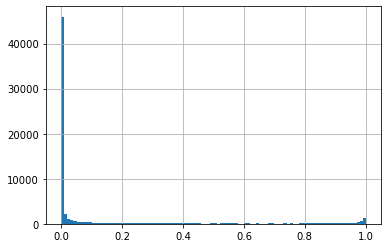

In [18]:
sub['toxic'].hist(bins=100)